## Imports

In [273]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torchvision import transforms
import matplotlib.pyplot as plt
import cv2
from PIL import Image

## Transformations for images

In [285]:
img_size = 512

transform = transforms.Compose([transforms.Resize(img_size),
                                transforms.CenterCrop(img_size),                                
                               transforms.ToTensor()])

transform_inv = transforms.Compose([transforms.Lambda(lambda x: x.clone()[0]),
                           transforms.Lambda(lambda x: x.data.clamp(0, 1)),
                           transforms.ToPILImage()   
                           ])

## Read and transform data

In [310]:
content = Image.open('painting.jpg')
style = Image.open('style1.jpg')

In [311]:
content = transform(content)
content = torch.unsqueeze(content, 0) #(1, 3, 512, 512)

style = transform(style)
style = torch.unsqueeze(style, 0) #(1, 3, 512, 512)

target = content.clone()

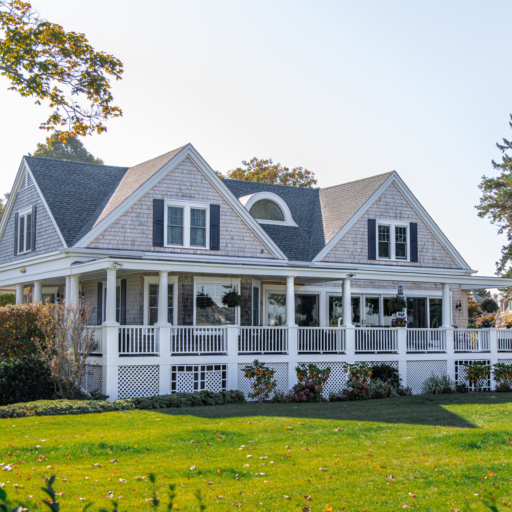

In [312]:
transform_inv(content)

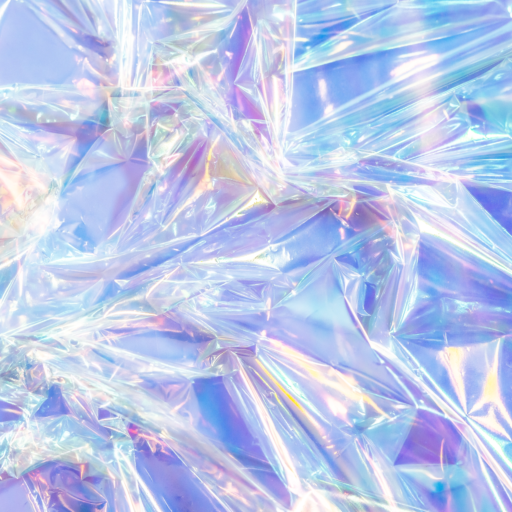

In [293]:
transform_inv(style)

## Modules for loss calculation

In [298]:
class ContentLoss(nn.Module):
    def __init__(self, content_map):
        super(ContentLoss, self).__init__()
        self.content_map = content_map.detach()

    def forward(self, x):
        self.loss = F.mse_loss(x, self.content_map)
        #Our white noise goes further into the next layer:
        return x 

class StyleLoss(nn.Module):

    def __init__(self, style_map):
        super(StyleLoss, self).__init__()
        self.style_gram = self._gram(style_map).detach()
    
    def _gram(self, map_):
        Nx, Cx, Hx, Wx = map_.size()  
        features = map_.view(Nx, Cx, Hx * Wx) 
        gram = torch.bmm(features, features.transpose(1,2))
        gram = gram.div(Hx * Wx)
        return gram

    def forward(self, x):
        G = self._gram(x)
        self.loss = F.mse_loss(G, self.style_gram)
        return x

In [302]:
def create_model(content_image, style_image):
    content_layers = ['conv1']
    style_layers = [f'conv{i+1}' for i in range(5)]
    
    i = 0
    
    content_losses = [] #only loss for conv4
    style_losses = []  #losses for conv1, conv1-conv2, conv1-conv3, conv1-conv4, conv1-conv5
    
    vgg = models.vgg19().features.eval()
    model = nn.Sequential()
    
    for layer in vgg.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu{i}'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name=f'pool{i}'
            layer = nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False)
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn{i}'

        model.add_module(name, layer)

        if name in content_layers:
            P_l = model(content_image).detach() #Get content_image representation on layer i
            content_loss = ContentLoss(P_l) #Get Loss_content (module) on layer i
            model.add_module(f"content_loss{i}", content_loss)
            content_losses.append(content_loss) #Losses for content image reconstruction (for total loss)

        if name in style_layers:
            A_l = model(style_image).detach() #Get style_image representation on layer i
            style_loss = StyleLoss(A_l) #Get Loss_style (module) on layer i
            model.add_module(f"style_loss{i}", style_loss)
            style_losses.append(style_loss) #Losses for style image reconstruction (for total loss)
        
        if i == 5:
            break
            
    return model, content_losses, style_losses

In [308]:
def train(content_image, style_image, target, epochs, style_weight, content_weight):
    model, style_losses, content_losses = create_model(style_image, content_image)
    optimizer = optim.Adam([target.requires_grad_()], lr = 0.1)
    for epoch in range(1, epochs + 1):
        
        def closure():
            
            optimizer.zero_grad()
            model(target)
            style_loss = 0
            content_loss = 0

            for sl in style_losses:
                style_loss += sl.loss
            for cl in content_losses:
                content_loss += cl.loss

            loss = style_loss * style_weight + content_loss * content_weight
            loss.backward()
            return loss
        
        optimizer.step(closure)

        plt.figure()
        plt.title(f'Epoch {epoch}')
        plt.imshow(transform_inv(target))
    
    return target

## Train model

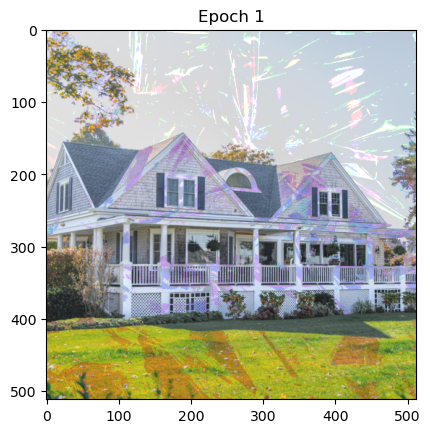

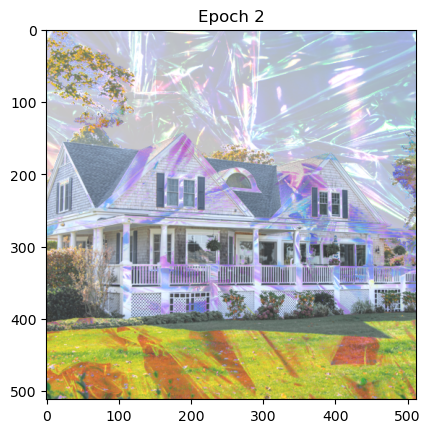

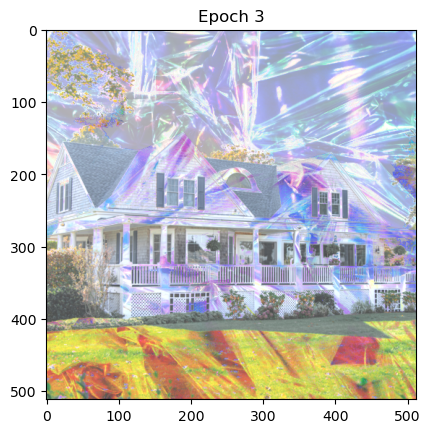

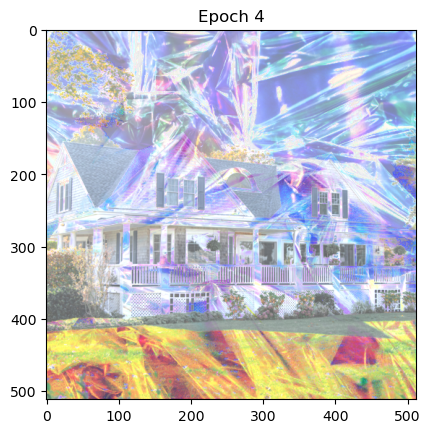

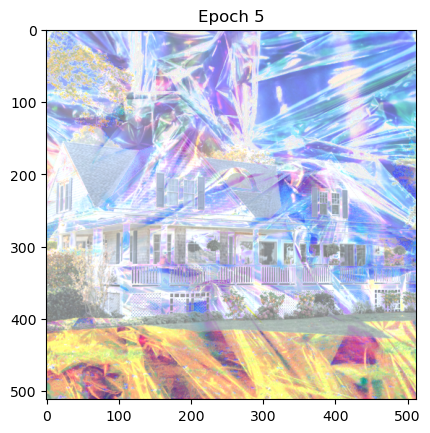

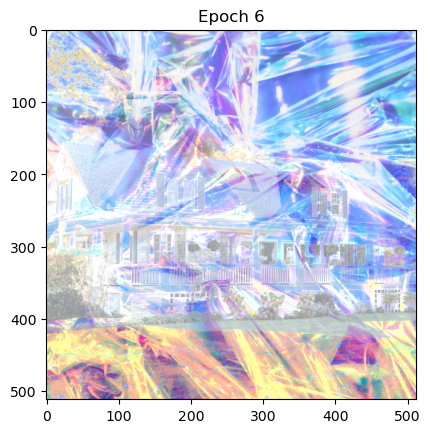

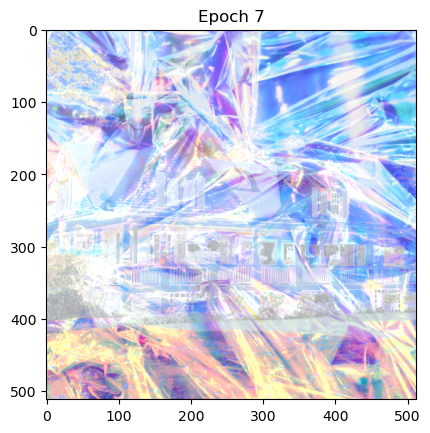

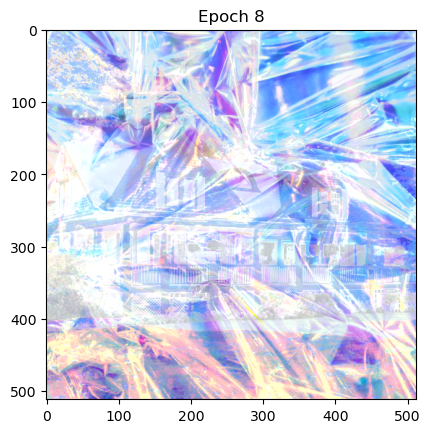

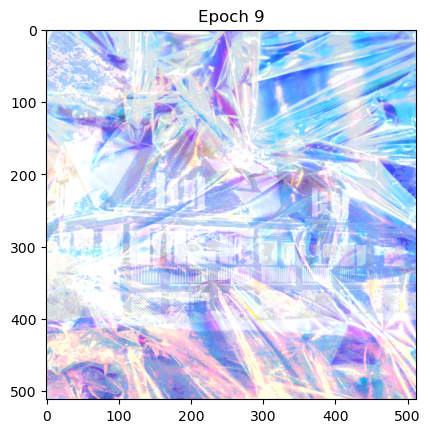

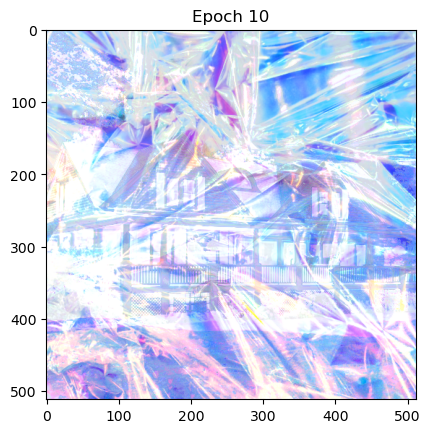

In [313]:
train(content, style, target, 10, 1e3, 1);